In [1]:
# Retail Sales: An End-to-End Analysis
### Project Goal
#This notebook explores a retail sales dataset to answer key business questions. I'll start with cleaning the data, then move into an exploratory analysis to find patterns in sales, top products, and store performance. Finally, I'll perform a deeper customer segmentation to identify our most valuable customers.

In [43]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px 
import seaborn as sns 
from prophet.plot import add_changepoints_to_plot 

df_raw = pd.read_csv('retail_store_sales1.csv')
print("This is the 'head' of the dataset\n", df_raw.head())

df = df_raw.copy() 
print("This is a working copy of the dataset as to not affect the original")

df.head() 

df.info()

df.describe().T


This is the 'head' of the dataset
   Transaction ID Customer ID       Category          Item  Price Per Unit  \
0    TXN_6867343     CUST_09     Patisserie   Item_10_PAT            18.5   
1    TXN_3731986     CUST_22  Milk Products  Item_17_MILK            29.0   
2    TXN_9303719     CUST_02       Butchers   Item_12_BUT            21.5   
3    TXN_9458126     CUST_06      Beverages   Item_16_BEV            27.5   
4    TXN_4575373     CUST_05           Food   Item_6_FOOD            12.5   

   Quantity  Total Spent  Payment Method Location Transaction Date  \
0      10.0        185.0  Digital Wallet   Online       2024-04-08   
1       9.0        261.0  Digital Wallet   Online       2023-07-23   
2       2.0         43.0     Credit Card   Online       2022-10-05   
3       9.0        247.5     Credit Card   Online       2022-05-07   
4       7.0         87.5  Digital Wallet   Online       2022-10-02   

  Discount Applied  
0             True  
1             True  
2            False

,count,mean,std,min,25%,50%,75%,max
Price Per Unit,11966.0,23.365912,10.743519,5.0,14.0,23.0,33.5,41.0
Quantity,11971.0,5.536380,2.857883,1.0,3.0,6.0,8.0,10.0
Total Spent,11971.0,129.652577,94.750697,5.0,51.0,108.5,192.0,410.0


In [26]:

## 1. Data Cleaning & Feature Engineering
#The `Date` column will be converted to a proper datetime format.
#A `Revenue` column will be created (`Price` * `Quantity`) to act as our primary performance metric.
#Missing `CustomerID` values will be filled with an 'Unknown' tag.

"\n## 1. Data Cleaning & Feature Engineering\n- The `Date` column will be converted to a proper datetime format.\n- A `Revenue` column will be created (`Price` * `Quantity`) to act as our primary performance metric.\n- Missing `CustomerID` values will be filled with an 'Unknown' tag.\n"

In [28]:
print("\n Missing Values before data cleansing")
print(df.isnull().sum())

#Dropping Total Spent beacuse this involves QTY and per_price unit which would make this unreliable
initial_rows = df.shape[0]
df.dropna(subset = ['Total Spent'], inplace = True) 
print(f"Dropped {initial_rows - df.shape[0]} rows due to missing 'Total spent'. New Shape: {df.shape}")




 Missing Values before data cleansing
Transaction ID         0
Customer ID            0
Category               0
Item                1213
Price Per Unit       609
Quantity             604
Total Spent          604
Payment Method         0
Location               0
Transaction Date       0
Discount Applied    4199
dtype: int64
Dropped 604 rows due to missing 'Total spent'. New Shape: (11971, 11)


In [29]:
#Filling missing values categorical values with 'Unknown' - these columns still hold a lot of value in forecasting so replace with NA
#instead of dropping column 
categorical_cols_to_fill = ['Item', 'Payment Method', 'Location', 'Discount Applied']
for col in categorical_cols_to_fill: 
    if col in df.columns:
        df[col].fillna('Unknown', inplace = True)

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

initial_rows_after_total_spent_drop = df.shape[0]
df.dropna(subset=['Transaction Date'], inplace=True)
print(f"Dropped {initial_rows_after_total_spent_drop - df.shape[0]} rows. New Shape:{df.shape}")

Dropped 0 rows. New Shape:(11971, 11)


/var/folders/7j/ml4t0dnd22v1_0cr33q3v8t00000gn/T/ipykernel_9833/987122886.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace = True)


In [30]:
#Handling invalid values 
df = df[df['Quantity']>0]
df = df[df['Price Per Unit']>0]
print(f"Removed rows with non-positive Qty or Price Per Unit. New Shape: {df.shape}")

#Verify Total spent consistency 
df['Calculated Total Spent'] = df['Quantity'] * df['Price Per Unit']

discrepancy_count = (np.abs(df['Total Spent'] - df['Calculated Total Spent']) > .01).sum()
if discrepancy_count > 0: 
    print(f"\n Warning: {discrepancy_count} rows have discrepancies between 'Total Spent' and 'Quantity' * 'Price Per Unit'.")
else: 
    print(f"\n 'Total Spent' column is consistent")


Removed rows with non-positive Qty or Price Per Unit. New Shape: (11362, 11)

 'Total Spent' column is consistent


In [31]:

## 2. Exploratory Data Analysis (EDA)
#With a clean and prepared dataset, I can now dig into the data to find insights.


'\n## 2. Exploratory Data Analysis (EDA)\nWith a clean and prepared dataset, I can now dig into the data to find insights.\n'

In [32]:
#What is the Overall Sales Trend Over time? 
#To get a high-level view of performance, I aggregated the total sales rev for each day and plot it. 


'\nWhat is the Overall Sales Trend Over time? \nTo get a high-level view of performance, I aggregated the total sales rev for each day and plot it. \n'

In [33]:
# Aggregate to Daily Time Series 

df.set_index('Transaction Date', inplace= True) 

#Dailly Frequency for time series ops
daily_sales = df['Total Spent'].resample('D').sum().reset_index()
#Not necessary in every time series forecasting just needed for prophet; Time column = ds and forecast = y
daily_sales.rename(columns = {'Transaction Date': 'ds', 'Total Spent':'y'}, inplace=True)

print(daily_sales.head())



          ds       y
0 2022-01-01  1642.5
1 2022-01-02  1135.5
2 2022-01-03   823.0
3 2022-01-04  1082.5
4 2022-01-05  2227.5


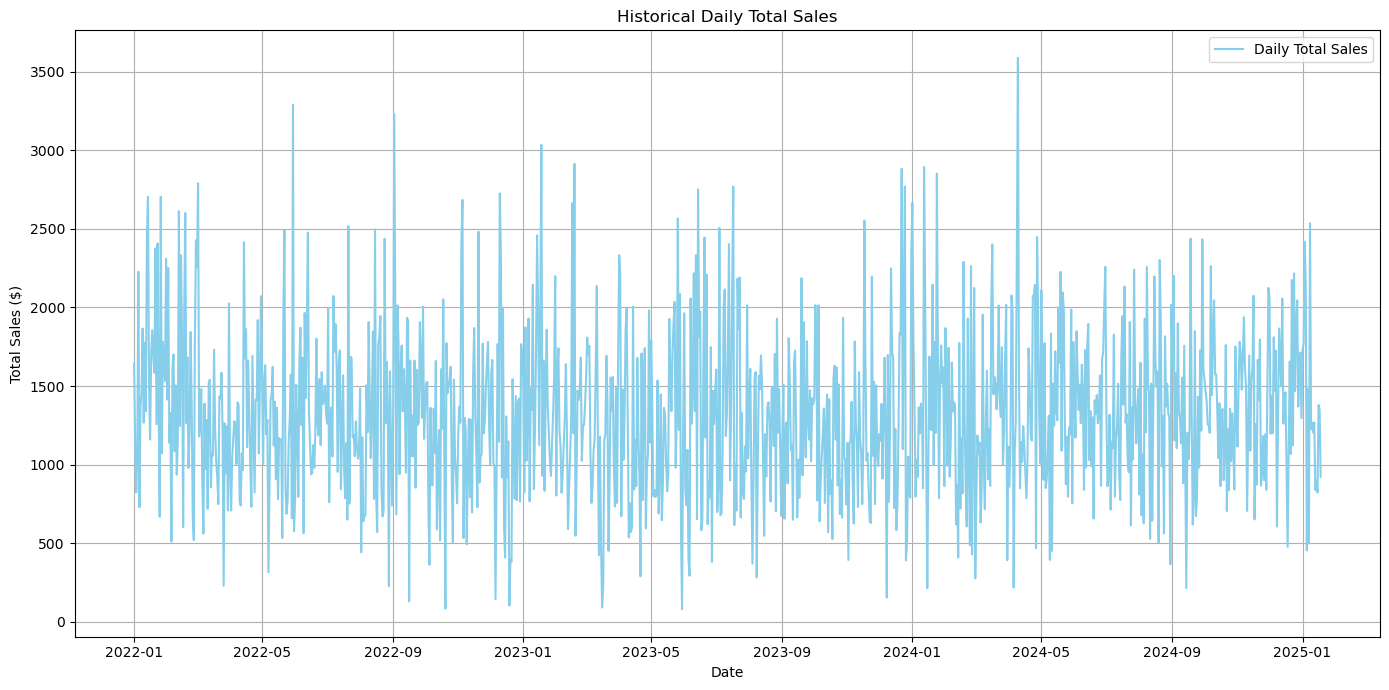

In [34]:
#EDA on timeseries

plt.figure(figsize=(14,7))
plt.plot(daily_sales['ds'], daily_sales['y'], label = 'Daily Total Sales', color='skyblue')
plt.title('Historical Daily Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/7j/ml4t0dnd22v1_0cr33q3v8t00000gn/T/ipykernel_9833/179852385.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values,ax=axes, palette='viridis')


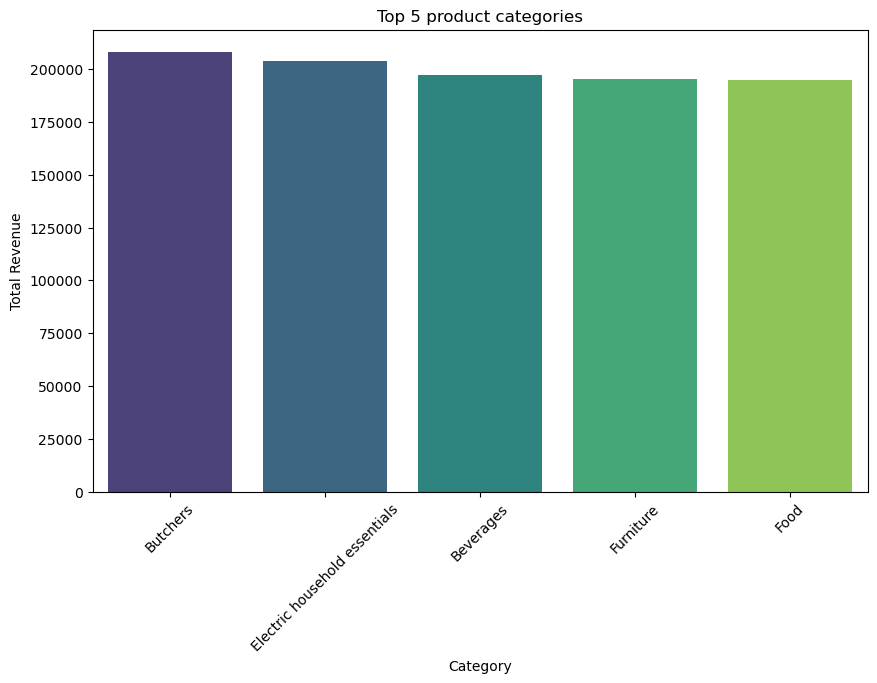

In [51]:
 #Top 5 Categories
fig, axes = plt.subplots(figsize=(10, 6))

top_categories = df.groupby('Category')['Total Spent'].sum().nlargest(5) 
sns.barplot(x=top_categories.index, y=top_categories.values,ax=axes, palette='viridis')
axes.set_title('Top 5 product categories') 
axes.set_ylabel('Total Revenue') 
axes.tick_params(axis='x', rotation=45) 

In [53]:
## 3. Time-Series Forecasting with Prophet
#After exploring the historical data. I'll use the Prophet library for time-series data with daily granularity.


"\n## 3. Time-Series Forecasting with Prophet\nAfter exploring the historical data. I'll use the Prophet library for time-series data with daily granularity.\n"

In [87]:
#Sales Forecasting 

model= Prophet(
    seasonality_mode='multiplicative', 
    weekly_seasonality=True, 
    yearly_seasonality=True
)

model.fit(daily_sales)
print("Model fitted Successfully.")


future = model.make_future_dataframe(periods=30, freq='D')
print(f"Future Dataframe created for {len(future)} periods (including historical).")

#Make Predictions 
forecast = model.predict(future)
print("\n Forecast generated")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

11:28:41 - cmdstanpy - INFO - Chain [1] start processing
11:28:41 - cmdstanpy - INFO - Chain [1] done processing


Model fitted Successfully.
Future Dataframe created for 1144 periods (including historical).

 Forecast generated
             ds         yhat  yhat_lower   yhat_upper
1139 2025-02-13  1395.976136  683.745315  2036.445777
1140 2025-02-14  1481.575001  840.930880  2143.270105
1141 2025-02-15  1427.268937  805.882569  2088.120367
1142 2025-02-16  1436.754738  770.726140  2111.540551
1143 2025-02-17  1354.832866  740.622171  1986.284144


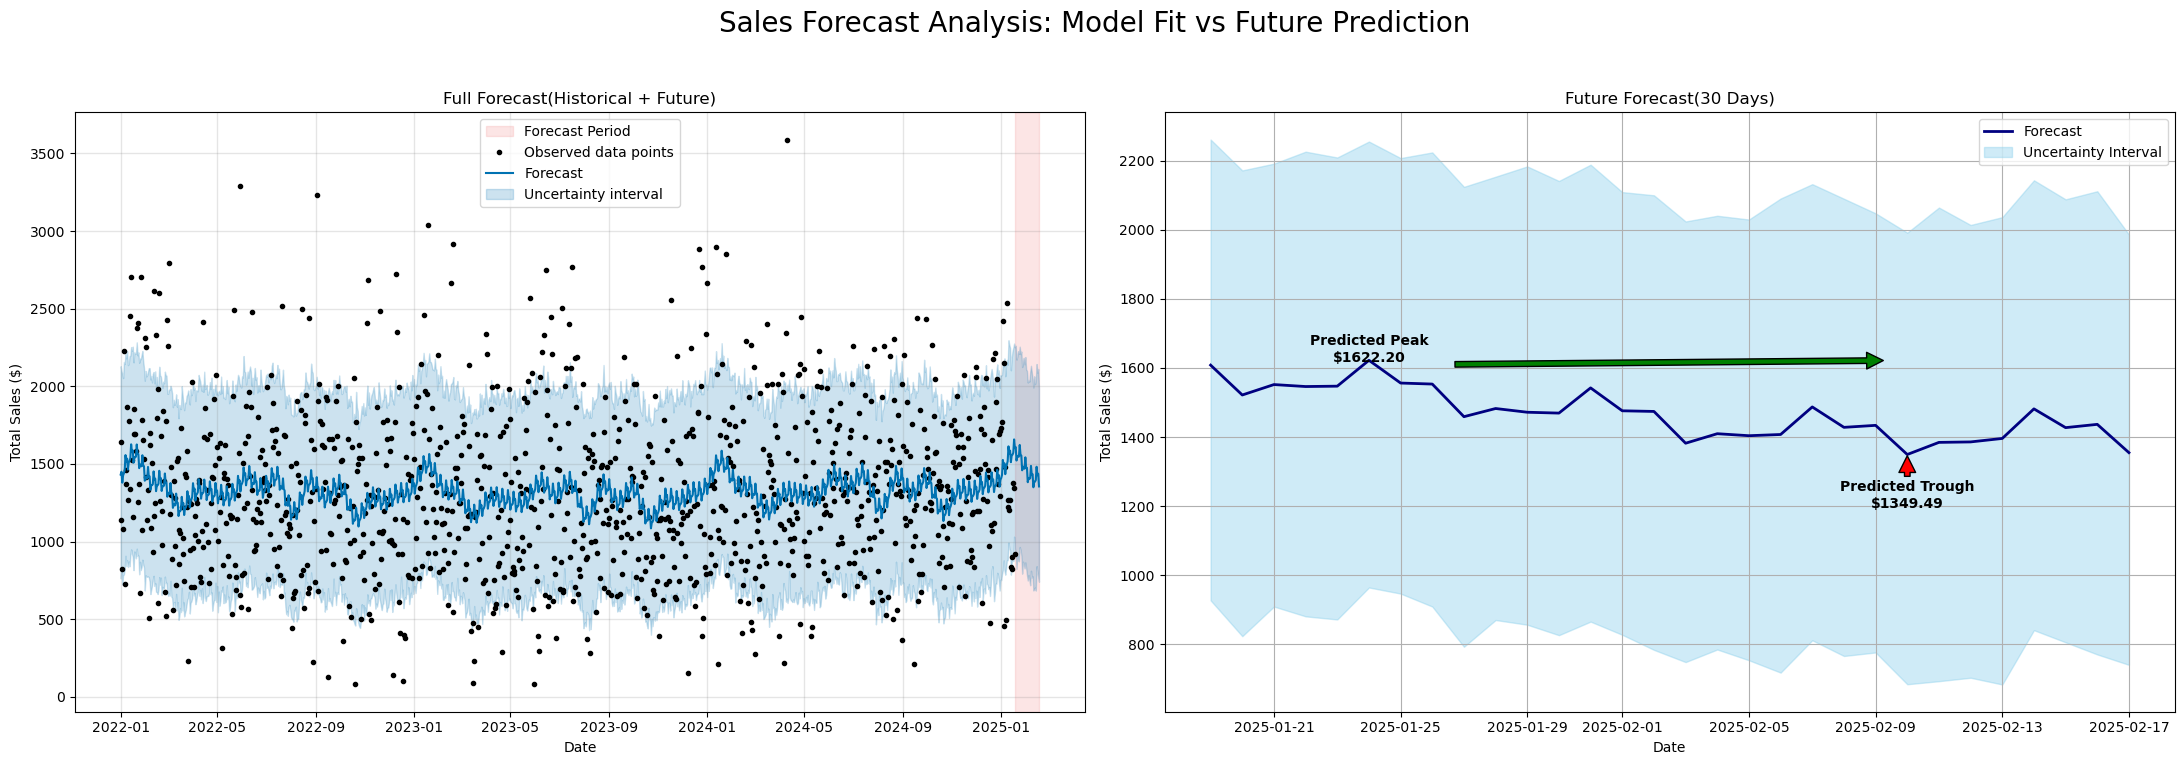

In [88]:
#Visualization 
fig, axes= plt.subplots(nrows =1, ncols=2, figsize=(22, 8))
fig.suptitle('Sales Forecast Analysis: Model Fit vs Future Prediction', fontsize=20)

#Seperating the historical from forecasted
last_hist_date = daily_sales['ds'].max()
axes[0].axvspan(last_hist_date, forecast['ds'].max(), color='lightcoral', alpha=.2, label='Forecast Period')

model.plot(forecast, ax=axes[0])
axes[0].set_title('Full Forecast(Historical + Future)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Sales ($)')
axes[0].legend()

future_forecast = forecast.tail(30)
axes[1].plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast', color='navy', lw=2)
axes[1].fill_between(future_forecast['ds'], 
                     future_forecast['yhat_lower'],
                     future_forecast['yhat_upper'],
                     color='skyblue', alpha=.4, label='Uncertainty Interval') 

#Annotating predicted sales days 
max_point = future_forecast.loc[future_forecast['yhat'].idxmax()]
min_point = future_forecast.loc[future_forecast['yhat'].idxmin()] 

axes[1].annotate(f'Predicted Peak\n${max_point['yhat']:.2f}',
                 xy=(min_point['ds'], max_point['yhat']), 
                 xytext=(max_point['ds'], max_point['yhat'] + 75), 
                 arrowprops=dict(facecolor='green', shrink=.05), 
                 ha='center', va='top', fontsize=10, fontweight='bold') 

axes[1].annotate(f'Predicted Trough\n${min_point["yhat"]:.2f}', 
                 xy=(min_point['ds'], min_point['yhat']),
                 xytext=(min_point['ds'], min_point['yhat'] - 75),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 ha='center', va='top', fontsize=10, fontweight='bold')

axes[1].set_title('Future Forecast(30 Days)') 
axes[1].set_xlabel('Date') 
axes[1].set_ylabel('Total Sales ($)') 
axes[1].grid(True)
axes[1].legend()

plt.tight_layout(rect=[0, .03, 1, .95])
plt.show()

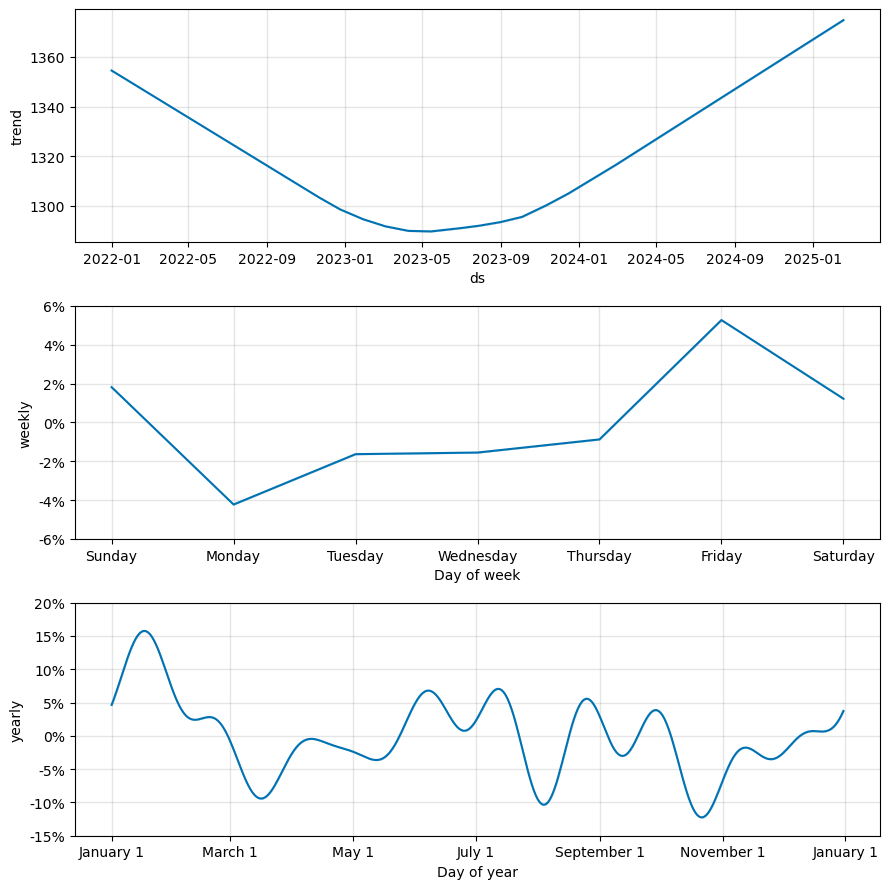

In [89]:
#Plot Forecast components
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()